## Data Processing and EDA

Below, we are going to do the following in order:

1. (Pre)Process the annotated labels and images into a single DataFrame
2. Perform a simple EDA
3. Run an ad effectiveness scoring function over the dataframe, and visualize the scores
4. A note on next steps in Kaggle

### Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 1. Data preprocessing

In [6]:
# Path to the folder containing the YOLO annotations
label_dir = '../data/raw_data/labels/'

# Define the mapping for class IDs to ad types
class_mapping = {0: 'ad_rectangle', 1: 'ad_square', 2: 'ad_vertical'}

# List to hold the data
data = []

# Iterate through each label file
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):  # Only process .txt files
        image_file = label_file.replace('.txt', '.png') 
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                # YOLO format: class_id x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                ad_type = class_mapping[int(class_id)]
                # Append to data list
                data.append([image_file, ad_type, x_center, y_center, width, height])

# Create a DataFrame from the collected data
cols = ['image_file', 'ad_type', 'x_center', 'y_center', 'width', 'height']
labels_df = pd.DataFrame(data, columns=cols)

# Display the first few rows of the DataFrame
labels_df.head()

,image_file,ad_type,x_center,y_center,width,height
0,hk.news.yahoo.com_mobile_20240829_133340_view_...,ad_rectangle,0.503704,0.281667,0.874074,0.055833
1,hk.news.yahoo.com_mobile_20240829_133340_view_...,ad_rectangle,0.487963,0.837708,0.875926,0.103750
2,businessmirror.com.ph_mobile_20240829_030758_v...,ad_rectangle,0.501389,0.105833,0.997222,0.210833
3,businessmirror.com.ph_mobile_20240829_030758_v...,ad_rectangle,0.500463,0.944792,0.999074,0.110417
4,libur.com.my_mobile_20240829_234000_view_2400.png,ad_square,0.500000,0.623542,0.838889,0.312083


In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_file  2450 non-null   object 
 1   ad_type     2450 non-null   object 
 2   x_center    2450 non-null   float64
 3   y_center    2450 non-null   float64
 4   width       2450 non-null   float64
 5   height      2450 non-null   float64
dtypes: float64(4), object(2)
memory usage: 115.0+ KB


So we have around 2450 ads annotated / labeled from the 1846 images downloaded through notebook1

### 2. EDA

Let's find the number of ads by classes (i.e. how many are rectangles, squares and vertical ads)

In [11]:
# Number of ads by type
ad_counts = labels_df['ad_type'].value_counts()
ad_counts

ad_type
ad_rectangle    1941
ad_square        386
ad_vertical      123
Name: count, dtype: int64

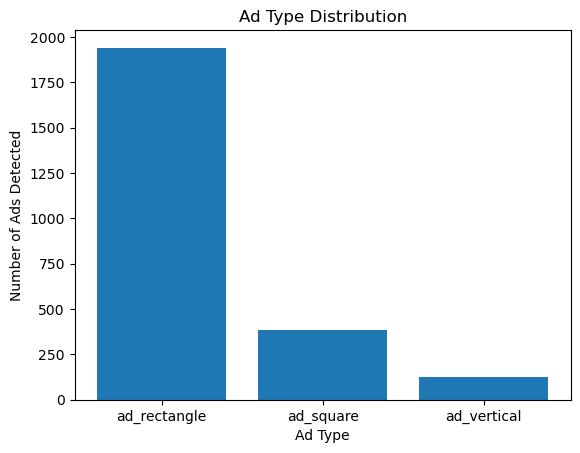

In [12]:
# Plot the ad type distribution
plt.bar(ad_counts.index, ad_counts.values)
plt.title('Ad Type Distribution')
plt.xlabel('Ad Type')
plt.ylabel('Number of Ads Detected')
plt.show()

Most ads from our dataset are therefore of type **_rectangle_** - this is a highly imbalanced dataset.

However, this distribution does mirror the ad size (shape) distribution across the internet (see below image from a proprietary ad server). So, we will go ahead with this dataset without any modifications during the model training.

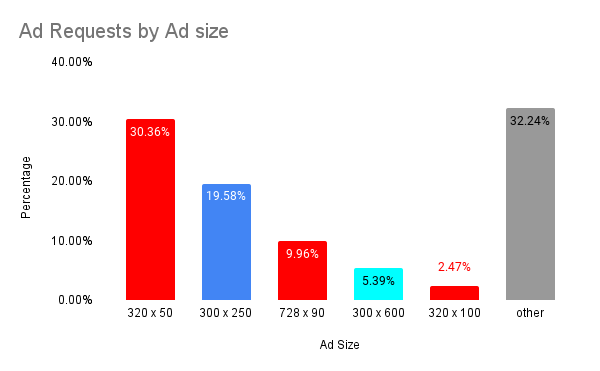

Now, it would be interesting the distribution for the number of ads per page.

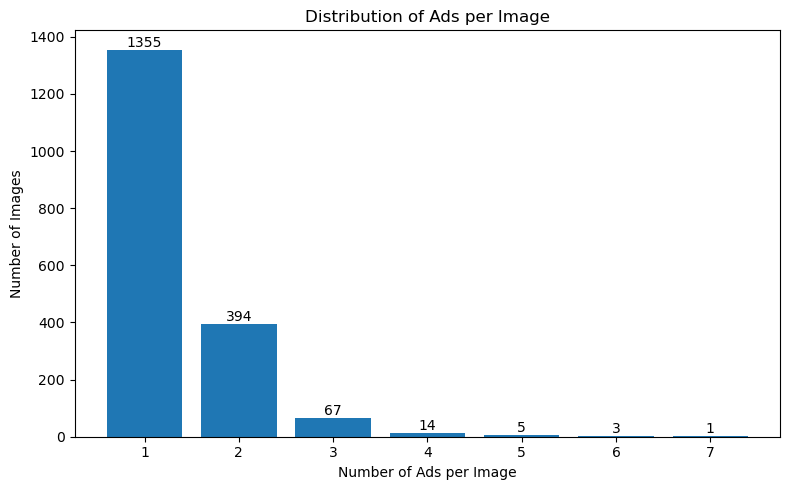

In [17]:
# Group by 'image_file' to count the number of ads per image
ads_per_image = labels_df.groupby('image_file').size()

# Count how many images have 1 ad, 2 ads, etc.
ads_frequency = ads_per_image.value_counts().sort_index()

# Plot the distribution of ads per image
plt.figure(figsize=(8, 5))
bars = plt.bar(ads_frequency.index, ads_frequency.values)
plt.title('Distribution of Ads per Image')
plt.xlabel('Number of Ads per Image')
plt.ylabel('Number of Images')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

From the above, its clear that the most web pages have one ad - however, about 20% of the pages scanned had 2 or more ads displayed.

### 3. Ad Effectiveness Score

The Ad effectiveness score, as a metric, relies on two clear concepts:

1. Every ad competes for attention with other ads on the page - we're terming this as **Ad Count ratio**

2. Every ad competes with the content on the page for attention from the user - also known as **Ad density**

For the Ad count ratio, we're relying on the IAB's Study - The Rules of Attention. Based on this, the maximum number of ads permissible on a page will be 2 for optimum attention and recall.

Ad density, on the other hand, is a concept being proposed by us, to be the ratio of an maximum ad area threshold (conservatively set to 30%) to the actual displayed ad area. 

There are other ways to calculate this, by setting a minimum area for content - however,setting a maximum threshold for ads seems more intuitive.

So, the 2 calculations are as below:

\begin{equation*}
  \text{Ad Count ratio}=\frac{2}{\text{number of ads on page}}
\end{equation*}

\begin{equation*}
  \text{Ad Density}=\frac{30\%}{\text{total area of ads on page}}
\end{equation*}

And finally, the Ad Effectiveness Score would be:

\begin{equation*}
  \text{Ad Effectiveness Score}=\text{Ad Count ratio}\times{\text{Ad Density}}
\end{equation*}

A couple of caveats:

1. The Ad count ratio can be never more than 1 - so if only one ad is served on a page, the ad count ratio is still 1

2. In Ad density, if there's no ad found, then the Ad effectiveness score is not calculated (to avoid division by zero).

The code below will do this in a step-by-step manner.

In [24]:
# Step 1: Define the function to get page area based on device type
def get_page_area(image_file):
    if 'mobile' in image_file:
        return 1080 * 2400  # Retina mobile resolution
    else:
        return 1654 * 2400  # Retina desktop resolution

# Step 2: Add a column for page area based on image_file in labels_df
labels_df['page_area'] = labels_df['image_file'].apply(get_page_area)

# Step 3: Calculate the ad area for each ad using YOLO width and height
# These values are normalized, so we multiply them by the page area to get the actual area
labels_df['ad_area'] = labels_df['width'] * labels_df['height'] * labels_df['page_area']

# Step 4: Group by 'image_file' to calculate ad count and total ad area
grouped_labels_df = labels_df.groupby('image_file').agg(
    ad_count=('ad_type', 'count'),          # Number of ads per image
    total_ad_area=('ad_area', 'sum'),       # Total ad area in each image
    page_area=('page_area', 'first')        # The page area remains constant for each image
).reset_index()

# Step 5: Define the ad effectiveness score function
def ad_effectiveness_score(ad_count, page_area, total_ad_area, 
                           ad_count_threshold=2, ad_area_threshold=0.3):
    # Calculate ad count score
    ad_count_score = min(1, ad_count_threshold / ad_count) if ad_count > 0 else 1
    # Calculate ad area score
    ad_area_score = min(1, (ad_area_threshold * page_area) / total_ad_area) if total_ad_area > 0 else 1
    # Final effectiveness score is the product of these two
    return ad_count_score, ad_area_score, ad_count_score * ad_area_score

# Step 6: Apply the ad effectiveness score to the grouped dataframe
grouped_labels_df[['ad_count_score', 'ad_area_score', 'ad_effectiveness']] = grouped_labels_df.apply(
    lambda row: pd.Series(ad_effectiveness_score(row['ad_count'], row['page_area'], row['total_ad_area'])),
    axis=1
)

# Step 7: Display the final DataFrame with ad effectiveness scores and component scores
print(grouped_labels_df[['image_file', 'ad_count', 'ad_count_score', 'ad_area_score', 'ad_effectiveness']])


                                             image_file  ad_count   
0     aljazeera.com_desktop_20240828_212219_view_248...         1  \
1     aljazeera.com_desktop_20240828_212219_view_330...         1   
2     aljazeera.com_desktop_20240828_212219_view_827...         1   
3     aljazeera.com_mobile_20240829_020436_view_3200...         1   
4     allabout-japan.com_desktop_20240828_212330_ful...         1   
...                                                 ...       ...   
1834  ph.news.yahoo.com_mobile_20240830_012156_view_...         1   
1835     www.ltn.com.tw_mobile_20240829_135457_full.png         1   
1836   www.ltn.com.tw_mobile_20240829_135457_view_0.png         1   
1837  www.ltn.com.tw_mobile_20240829_135457_view_240...         1   
1838  www.ltn.com.tw_mobile_20240829_135457_view_320...         1   

      ad_count_score  ad_area_score  ad_effectiveness  
0                1.0       1.000000          1.000000  
1                1.0       1.000000          1.000000  
2  

In [25]:
grouped_labels_df.head()

,image_file,ad_count,total_ad_area,page_area,ad_count_score,ad_area_score,ad_effectiveness
0,aljazeera.com_desktop_20240828_212219_view_248...,1,4.003276e+05,3969600,1.0,1.000000,1.000000
1,aljazeera.com_desktop_20240828_212219_view_330...,1,4.002479e+05,3969600,1.0,1.000000,1.000000
2,aljazeera.com_desktop_20240828_212219_view_827...,1,9.758891e+05,3969600,1.0,1.000000,1.000000
3,aljazeera.com_mobile_20240829_020436_view_3200...,1,1.602828e+06,2592000,1.0,0.485143,0.485143
4,allabout-japan.com_desktop_20240828_212330_ful...,1,9.676135e+04,3969600,1.0,1.000000,1.000000


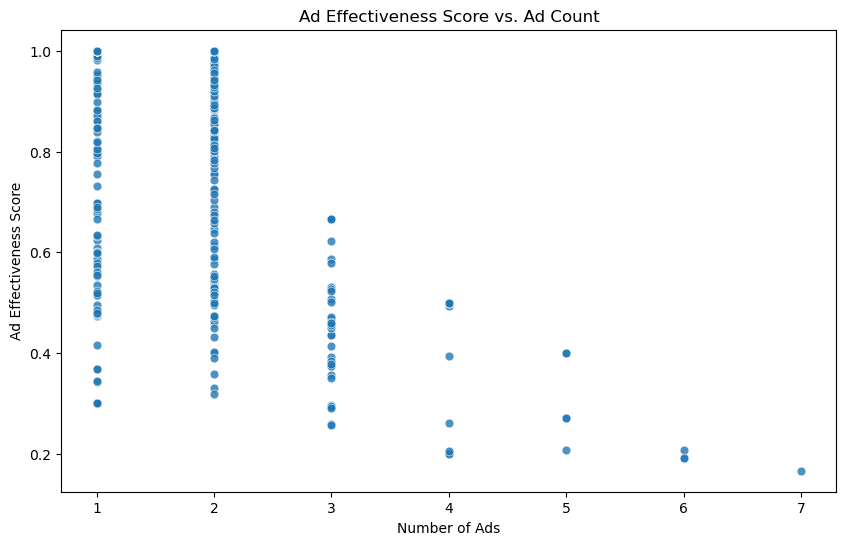

In [27]:
# Scatter plot: Ad Count vs Ad Effectiveness Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ad_count', y='ad_effectiveness', data=grouped_labels_df, s=40, alpha=0.8)
plt.title('Ad Effectiveness Score vs. Ad Count')
plt.xlabel('Number of Ads')
plt.ylabel('Ad Effectiveness Score')
plt.show()

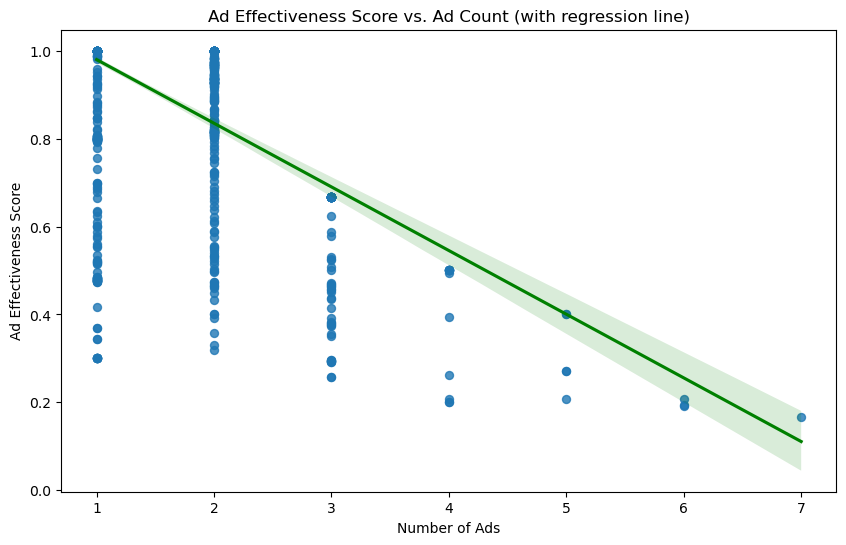

In [28]:
# Scatter plot with regression line: Ad Count vs Ad Effectiveness Score
plt.figure(figsize=(10, 6))
sns.regplot(x='ad_count', y='ad_effectiveness', data=grouped_labels_df, scatter_kws={'s':33, 'alpha':0.8}, line_kws={'color':'green'})
plt.title('Ad Effectiveness Score vs. Ad Count (with regression line)')
plt.xlabel('Number of Ads')
plt.ylabel('Ad Effectiveness Score')
plt.show()

With the regression applied to the scatter plot, we can see easily see that the ad effectiveness falls from close to 1, to less than 0.2 as the number of ads on a page increase.

### 4. Next Steps in Kaggle

As I had chosen the YOLO format for annotation, my choice for the CV model would logically be the YOLO series of models.

I chose YOLOv5[link](https://github.com/ultralytics/yolov5) and YOLOv8[link](https://github.com/ultralytics/ultralytics) as they're known to be fast at object detection, and have extensive documentation.
I left most of the model settings on default, as the documentation included was quite comprehensive.

As there are no classes for ad types and formats, we used transfer learning - i.e. ran the pre-trained models on the train set of images and labels.

Due to hardware limits, we opted to run everything on Kaggle - we've included links to the notebooks as needed below.

#### Training summary on Kaggle

|Model| Runs|mAP-50 score| Best model run|Time taken|Link to notebook|GPU|
|-|-|-|-|-|-|-|
|YOLOv5|50|90.0|49|1 hr 57 mins|[link](https://www.kaggle.com/code/kampungkat/yolov5-gpu)|Tesla P100-PCIE-16GB|
|**YOLOv8**|**50**|**93.4**|**48**|**42 mins**|**[link](https://www.kaggle.com/code/kampungkat/yolov8-gpu)**|**Tesla P100-PCIE-16GB**|
|YOLOv8|50|93.4|48|9 hrs 18 mins|[link](https://www.kaggle.com/code/kampungkat/yolov8-cpu-9h/notebook)|no|

The YOLOv8 model on GPU was the best performing model, both in terms of time as well as mean Average Precision (mAP-50) scores.

For logging, the YOLO models support logging with wandb.ai's platform -  the wandb report from the model's successful training run has been included in the repository

Finally, here's the confusion matrix for the validation set:

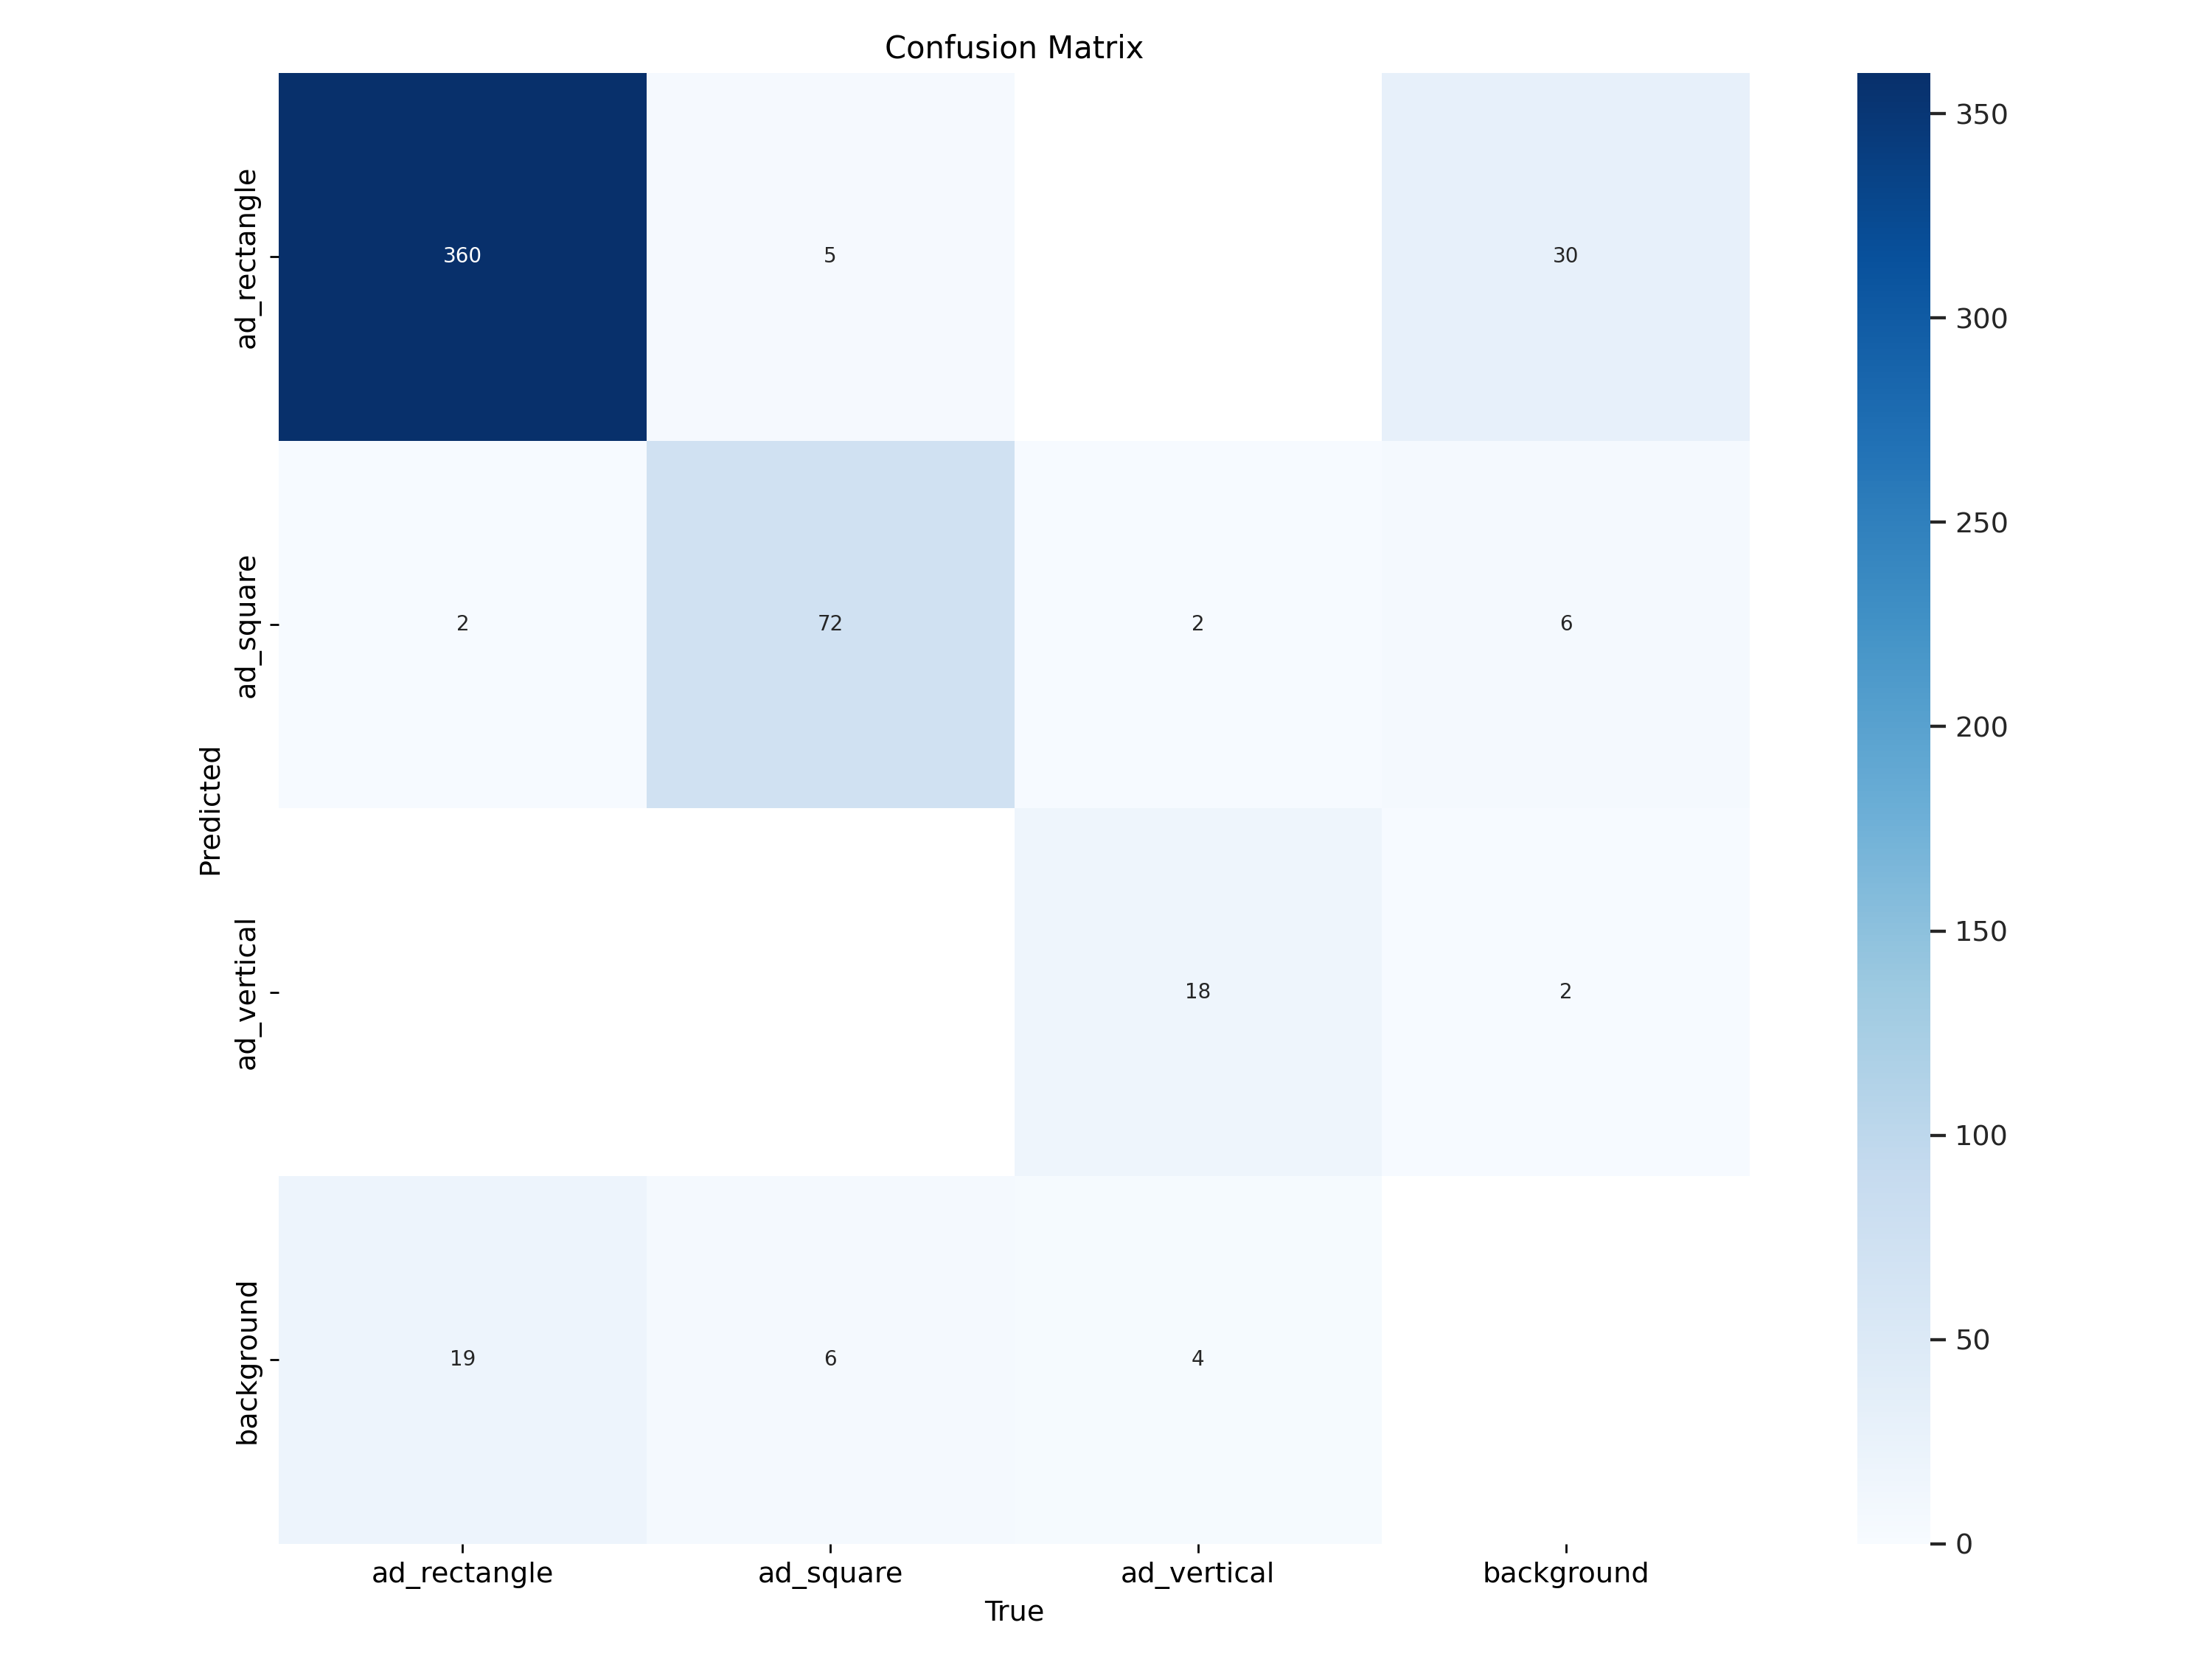

Even though the data is skewed, we can see that the model is performing really well with just about 10% false positives from the validation set.

### 5. Predicting with the best model

The best model from the YOLOv8 run has been saved in the /kaggle_code folder as **best.pt**.

The predict task based on the best.pt model, is running here - https://www.kaggle.com/code/kampungkat/ad-detection
This is called within the Streamlit app - app.py - to predict and detect ads on unseen images.

The model is also available on Kaggle here - https://www.kaggle.com/models/kampungkat/ad_detection_yolov8/PyTorch/default/1

### Summary

1. As a Proof-of-Concept, we can ascertain ad effectiveness as a combination of ad count and ad density on a page.
2. We took off the shelf computer vision models from the Ultralytics YOLO series (v5 and v8), and ran transfer learning training to identify 3 ad classes
3. The YOLOv8 model performed the best with low training times (on GPU) and with highest mAP-50 score.

The Streamlit app (app.py)